# 階層ベイズ

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 訓練データ生成

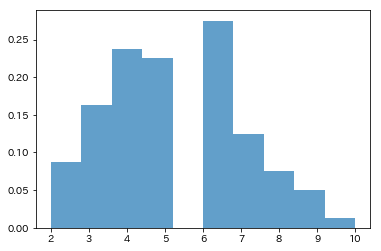

In [2]:
n = 20
x = np.random.binomial(n, 0.25, size=100)
_ = plt.hist(x, bins=10, alpha=0.7, normed=True)

## 学習

階層ベイズとは階層的にパラメータの分布を表現したモデルである。

データを$X$、パラメータ$\theta$に対する尤度関数を$p(X | \theta)$、$\theta$の事前分布を$p(\theta | \phi)$、$\phi$の事前分布を$p(\phi)$とすると、

事後確率は$p(\theta, \phi| X)  = \frac{p(X | \theta) p(\theta | \phi) p(\phi)}{p(X)}$となる

訓練データを$X = [x_{1}, x_{2}, ..., x_{N}]^{\mathrm{T}}$とする。

モデルとして$p(x | \rho) = \text{Binominal}(x | n, \sigma(\rho))$（二項分布）というモデルを考える。ただし、$\sigma(\cdot)$はシグモイド関数、$n$は定数とする。

パラメータ$\rho$は以下のガウス分布に従うと仮定する。

$p(\rho | \mu, \tau) = \mathcal{N}(\rho | \mu, \tau^{-1})$

さらに$\mu, \tau$はそれぞれ以下のガウス分布、ガンマ分布に従うとする。

$p(\mu | \mu_{0}, \eta_{0}) = \mathcal{N}(\mu | \mu_{0}, \eta_{0}^{-1})$

$p(\tau | a_{0}, b_{0}) = \text{Gam} (\tau | a_{0}, b_{0})$

ただし、$\mu_{0}, \eta_{0}, a_{0}, b_{0}$は定数とする。

このとき事後分布は、$p(\rho, \mu, \tau | X; \mu_{0}, \eta_{0}, a_{0}, b_{0}) = \frac{p(x | \rho) p(\rho | \mu, \tau) p(\mu | \mu_{0}, \eta_{0}) p(\tau | a_{0}, b_{0})}{p(X)}$となる。

### マルコフ連鎖モンテカルロ法（MCMC）

解析的に事後分布が求められない場合に、事後分布をサンプリングによって求めることを考える。

今回はメトロポリス法を用いる。メトロポリス法の手順は以下の通りである。

1. パラメータを初期化する。

2. 確率変数を以下のようにサンプルする。  
$\mu \sim p(\mu | \mu_{0}, \eta_{0})$  
$\tau \sim p(\tau | a_{0}, b_{0})$  
$\rho \sim p(\rho | \mu, \tau)$

3. 採択率$\alpha=f(\rho) / f(\rho_{t})$を計算する。($f(\rho)$は尤度$p(X | \rho)$とする)

4. 確率$\alpha$でサンプルを採択し($\rho_{t+1} = \rho$)、採択しない場合は$\rho_{t+1} = \rho_{t}$とする。

### パラメータの事前分布

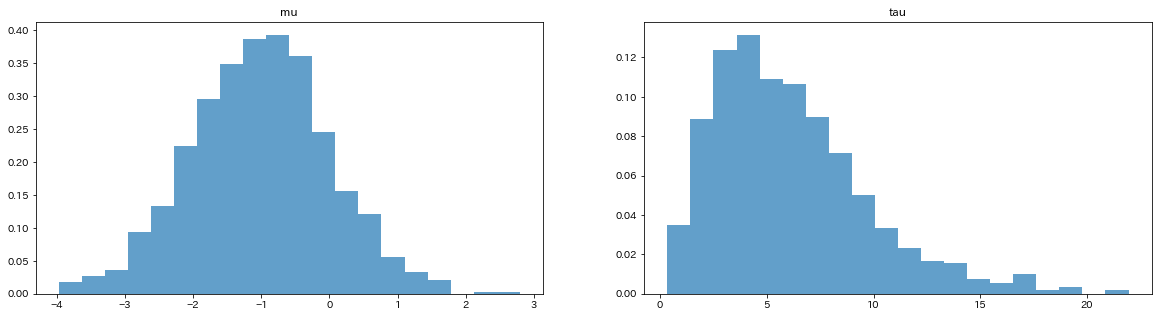

In [3]:
mu0 = -1.
eta0 = 1.
a0 = 3.
b0 = 2.

mu_prior = np.random.normal(loc=mu0, scale=1./eta0, size=1000)
tau_prior = np.random.gamma(shape=a0, scale=b0, size=1000)

plt.figure(figsize=(20, 5))
ax1 = plt.subplot(1, 2, 1)
_ = plt.hist(mu_prior, bins=20, alpha=0.7, normed=True)
ax1.set_title('mu')

ax2 = plt.subplot(1, 2, 2)
_ = plt.hist(tau_prior, bins=20, alpha=0.7, normed=True)
ax2.set_title('tau')

In [4]:
from scipy import misc

def sigmoid(x):
    return 1. / (1 + np.exp(-x))

e = 1e-9
def log_likelihood(X, rho):
    p = sigmoid(rho)
    return np.sum( np.log(misc.comb(n, X)) + X*np.log(p + e) + (n-X)*np.log(1-p + e) ) 

max_iter = 100000
# 最初の方は捨てる
burn_in = 10000
# mu, tau, rho
params = np.zeros((max_iter, 3))
mu = 0.
tau = 0.1
rho = 0.5
for i in range(max_iter):
    _mu = np.random.normal(loc=mu0, scale=1./eta0)
    _tau = np.random.gamma(shape=a0, scale=b0)  
    _rho = np.random.normal(loc=_mu, scale=1./_tau)
    
    alpha = np.exp(log_likelihood(x, _rho) - log_likelihood(x, rho))
    if np.random.random() < alpha:
        mu, tau, rho = _mu, _tau, _rho
    if i >= burn_in:
        params[i] = [mu, tau, rho]

## 結果

### ステップ数とパラメータの値

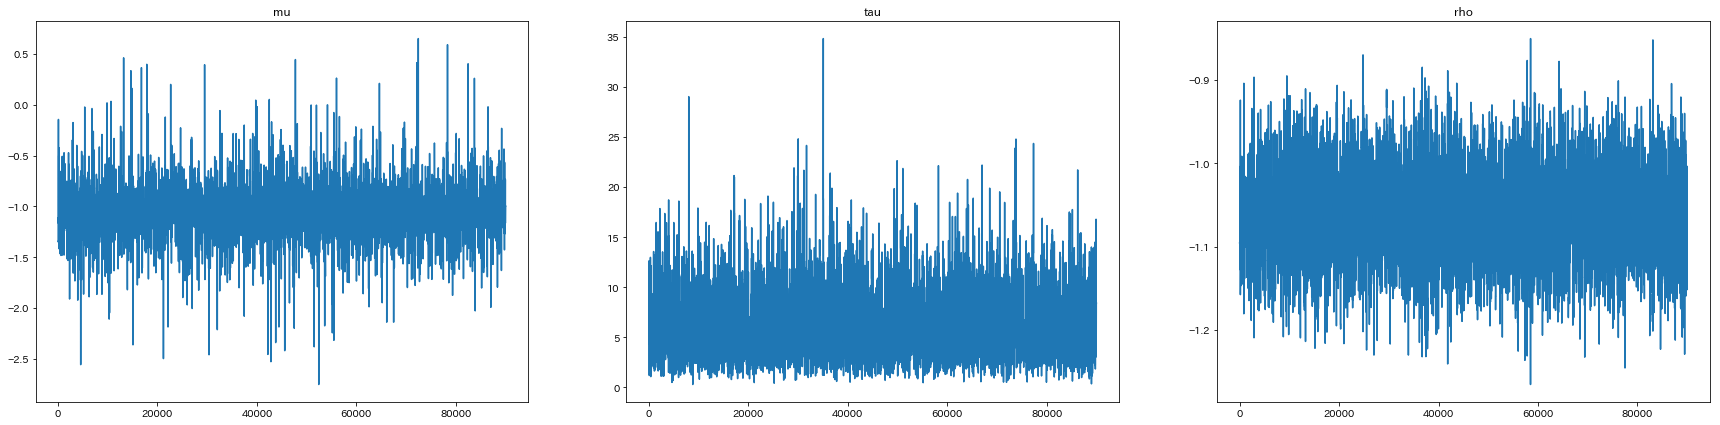

In [5]:
plt.figure(figsize=(30, 7))
ax1 = plt.subplot(1, 3, 1)
plt.plot(params[burn_in:, 0])
ax1.set_title('mu')
ax2 = plt.subplot(1, 3, 2)
plt.plot(params[burn_in:, 1])
ax2.set_title('tau')
ax3 = plt.subplot(1, 3, 3)
plt.plot(params[burn_in:, 2])
ax3.set_title('rho')

### パラメータの事後分布

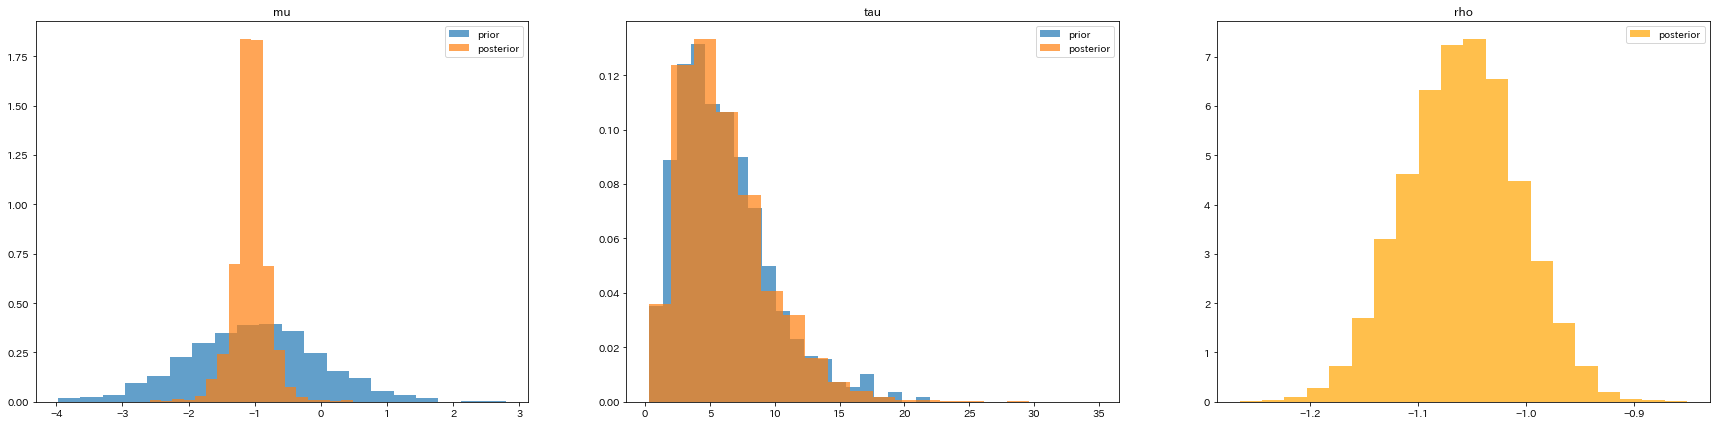

In [6]:
plt.figure(figsize=(30, 7))
ax1 = plt.subplot(1, 3, 1)
_ = plt.hist(mu_prior, bins=20, alpha=0.7, normed=True, label='prior')
_ = plt.hist(params[burn_in:, 0], bins=20, alpha=0.7, normed=True, label='posterior')
ax1.set_title('mu')
ax1.legend()

ax2 = plt.subplot(1, 3, 2)
_ = plt.hist(tau_prior, bins=20, alpha=0.7, normed=True, label='prior')
_ = plt.hist(params[burn_in:, 1], bins=20, alpha=0.7, normed=True, label='posterior')
ax2.set_title('tau')
ax2.legend()

ax3 = plt.subplot(1, 3, 3)
_ = plt.hist(params[burn_in:, 2], bins=20, alpha=0.7, normed=True, label='posterior', color='orange')
ax3.set_title('rho')
ax3.legend()

### 推定

得られたパラメータの中央値を利用して分布を推定する。

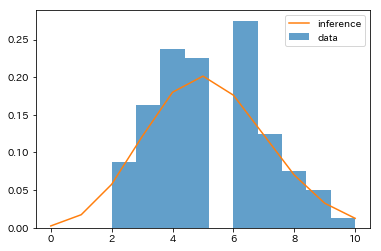

In [7]:
def pdf(x, p):
    # binominal
    return misc.comb(n, x) * p**x * (1-p)**(n-x)

rho_median = np.median(params[:, 2])
p_median = sigmoid(rho_median)
xx = np.arange(11)
_pdf = pdf(xx, p_median)

_ = plt.hist(x, bins=10, alpha=0.7, normed=True, label='data')
plt.plot(xx, _pdf, label='inference')
plt.legend()